In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging
tf.get_logger().setLevel(logging.ERROR)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Load data

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
(train.shape, test.shape)

((42000, 785), (28000, 784))

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare data

In [5]:
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test

In [6]:
X_train = X_train.values.reshape(len(X_train), 28, 28)
X_test = X_test.values.reshape(len(X_test), 28, 28)

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Show data

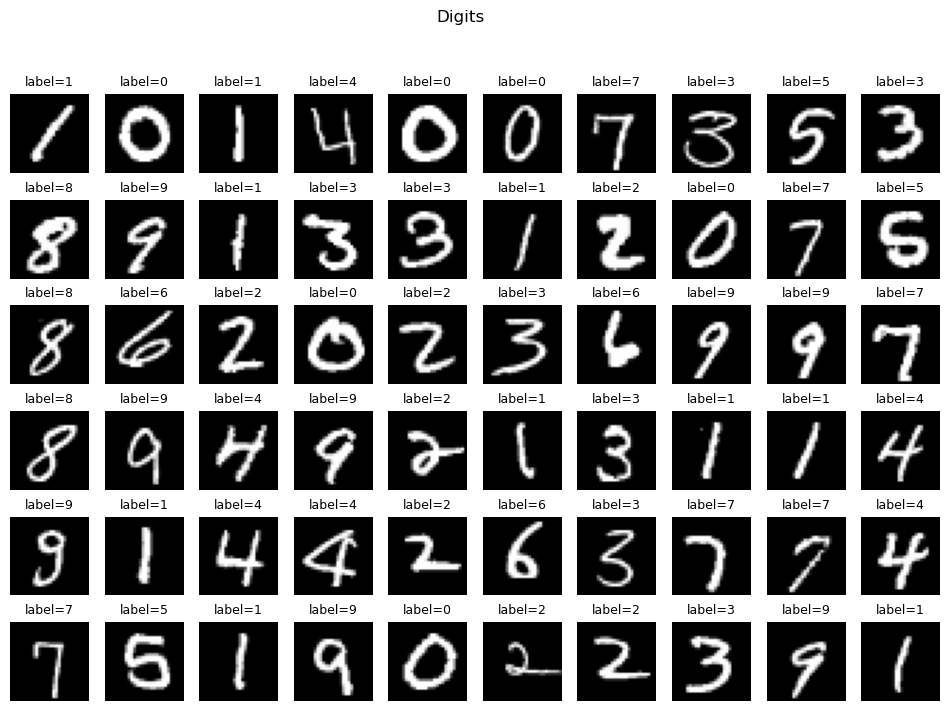

In [8]:
n_cols, n_rows = 10, 6

plt.figure(figsize=(12,8))
plt.suptitle('Digits')
for i in range(n_cols * n_rows):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('label={}'.format(y_train[i]), fontsize=9)
    plt.axis('off')

<AxesSubplot:xlabel='label', ylabel='count'>

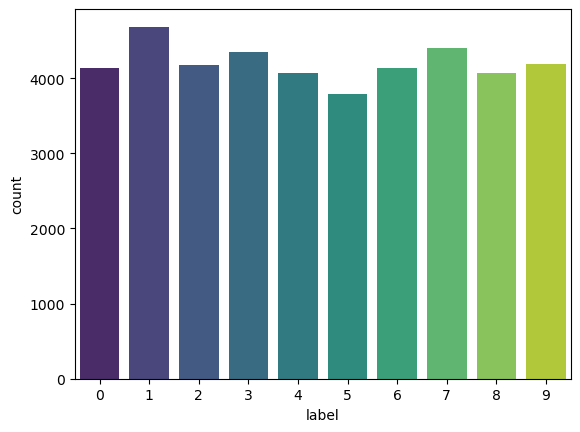

In [9]:
sns.countplot(x=y_train, palette='viridis')

# Data augmentation

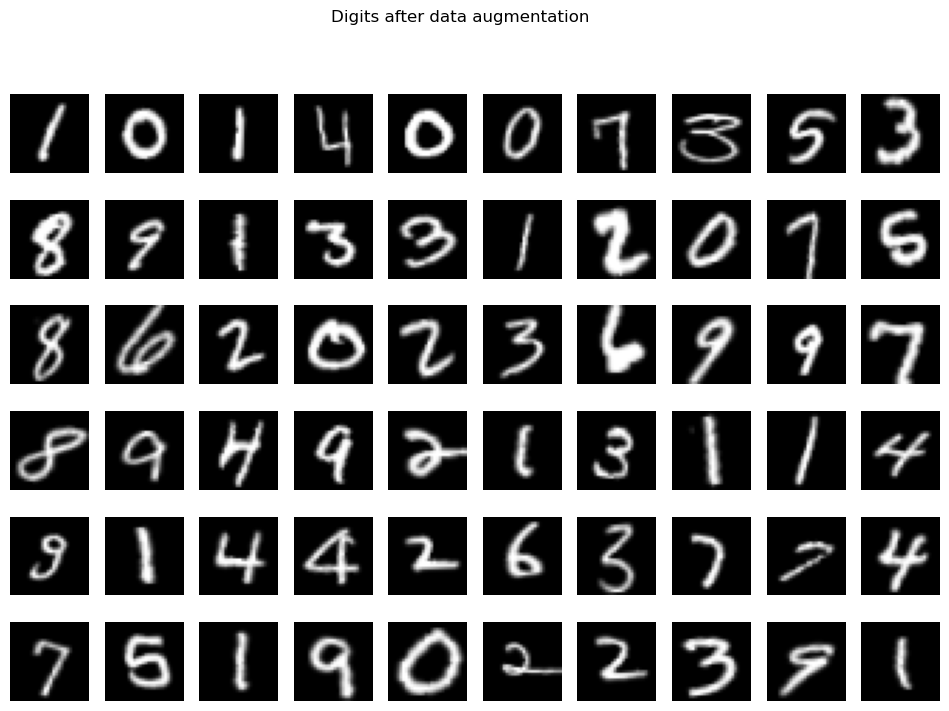

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomZoom(0.2, 0.2, fill_mode='constant', fill_value=0.0)
])

n_cols, n_rows = 10, 6

plt.figure(figsize=(12,8))
plt.suptitle('Digits after data augmentation')
for i in range(n_cols * n_rows):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(data_augmentation(np.expand_dims(X_train[i], -1)), cmap='gray')
#     plt.title('label={}'.format(y_train[i]), fontsize=9)
    plt.axis('off')

# CNN model

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.RandomRotation(0.05, fill_mode='constant', fill_value=0.0, input_shape=[28, 28, 1]))
# model.add(tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode='constant', fill_value=0.0))
model.add(tf.keras.layers.RandomZoom(0.2, 0.2, fill_mode='constant', fill_value=0.0))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)       

In [14]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [15]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=2)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks, validation_data=[X_valid, y_valid])

Epoch 1/100


2023-03-01 11:59:32.515349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1050/1050 [==============================] - 183s 164ms/step - loss: 0.3117 - accuracy: 0.9003 - val_loss: 0.0820 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 2/100
1050/1050 [==============================] - 171s 163ms/step - loss: 0.1122 - accuracy: 0.9668 - val_loss: 0.0763 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 3/100
1050/1050 [==============================] - 174s 165ms/step - loss: 0.0887 - accuracy: 0.9729 - val_loss: 0.0488 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 4/100
1050/1050 [==============================] - 170s 162ms/step - loss: 0.0753 - accuracy: 0.9765 - val_loss: 0.0342 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 5/100
1050/1050 [==============================] - 171s 163ms/step - loss: 0.0689 - accuracy: 0.9792 - val_loss: 0.0298 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/100
1050/1050 [==============================] - 170s 162ms/step - loss: 0.0657 - accuracy: 0.9807 - val_loss: 0.0439 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 7/100
1050/1050 [=================

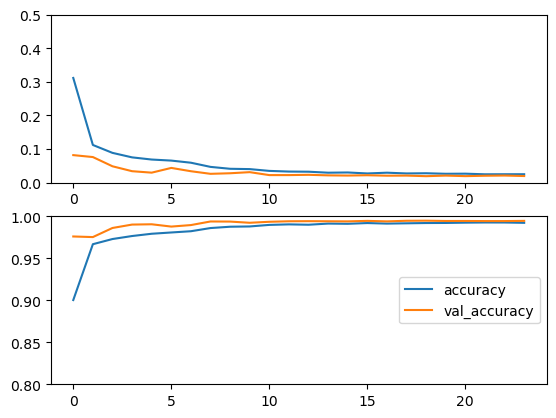

In [16]:
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_ylim([0, 0.5])
ax[1].legend(['loss', 'val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_ylim([0.8, 1])
ax[1].legend(['accuracy', 'val_accuracy'], loc='center right')

# Analyze predictions on validation set

In [17]:
y_valid_pred = model.predict(X_valid)

263/263 [==============================] - 1s 2ms/step


Text(70.72222222222221, 0.5, 'y_valid_true')

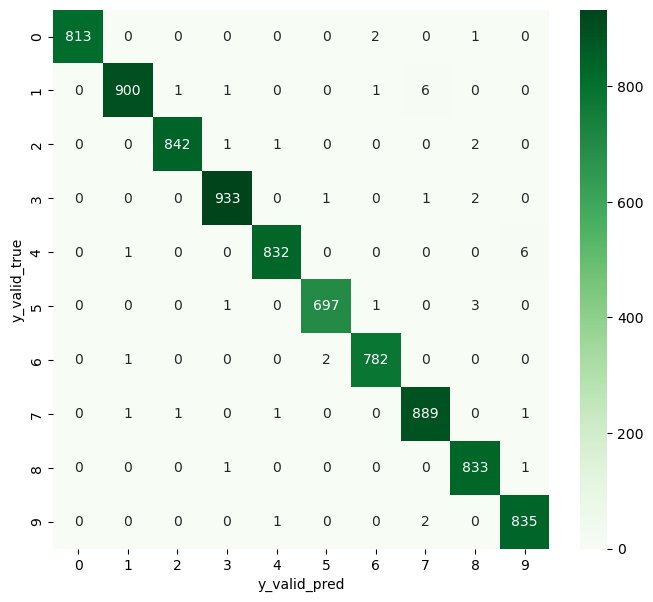

In [18]:
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_valid, np.argmax(y_valid_pred, axis=1)), annot=True, cmap='Greens', fmt='d')
plt.xlabel('y_valid_pred')
plt.ylabel('y_valid_true')

In [19]:
df = pd.DataFrame(np.stack([y_valid, np.argmax(y_valid_pred, axis=1)]).T,\
                  columns=['y_valid_true', 'y_valid_pred'])
df = df[df['y_valid_true'] != df['y_valid_pred']]

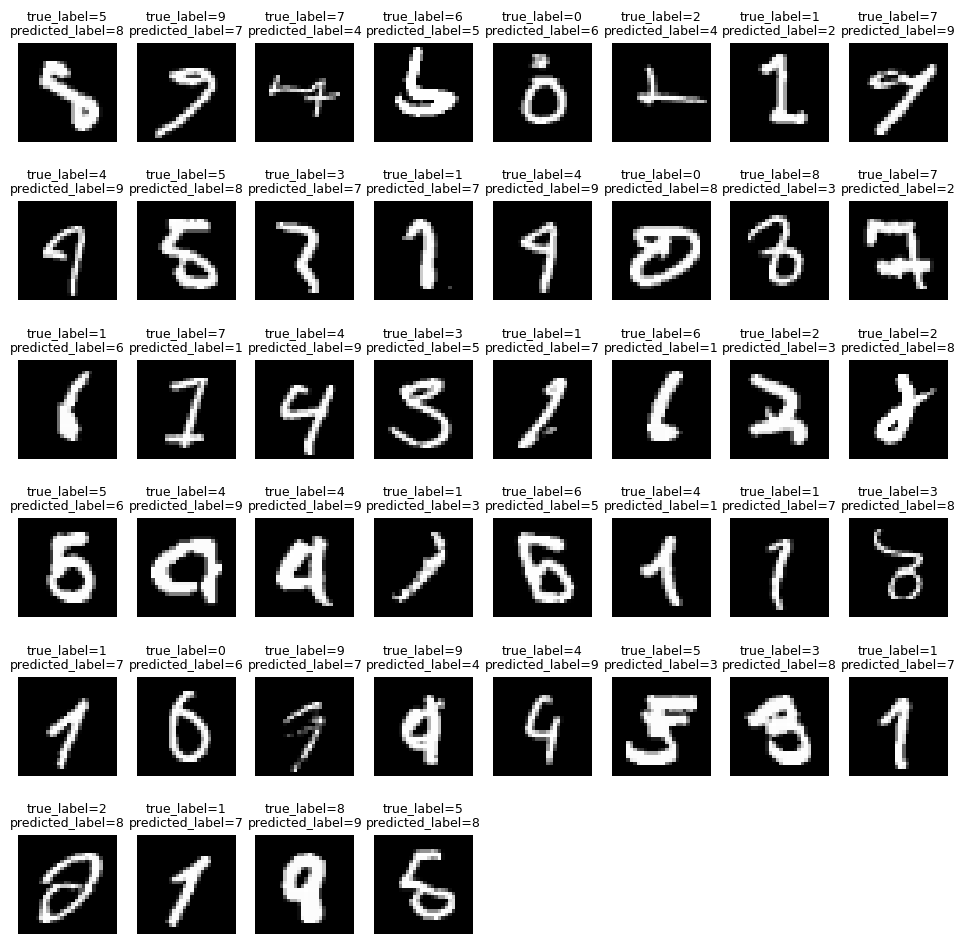

In [20]:
n_cols, n_row = 8, 6

plt.figure(figsize= (12,12))
for i in range(np.min([n_cols*n_rows, len(df)])):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_valid[df.index[i]], cmap='gray')
    plt.title('true_label={}\npredicted_label={}'\
              .format(df.loc[df.index[i], 'y_valid_true'], df.loc[df.index[i], 'y_valid_pred']),\
              fontsize=9)
    plt.axis('off')

# Make predictions on test set

In [21]:
y_pred = model.predict(X_test)

875/875 [==============================] - 2s 2ms/step


In [22]:
submission = pd.DataFrame(np.stack([np.arange(1, len(X_test)+1), np.argmax(y_pred, axis=1)]).T,\
                          columns=['ImageId', 'Label'])
submission.to_csv("submission.csv",index=False)